# Modelamiento

## Preprocessing

In [158]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.impute import SimpleImputer
from scipy.sparse import csr_matrix, hstack
import pandas as pd
from joblib import dump, load
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision
from sklearn.model_selection import train_test_split

In [73]:
data = pd.read_csv("../data/interim/loan_cleaned.csv")

C:\Users\JUAN\AppData\Local\Temp\ipykernel_93276\4155631503.py:1: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/interim/loan_cleaned.csv")


In [74]:
date_columns = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

In [75]:
imputer = SimpleImputer(strategy="constant", fill_value="")
imputer.fit(data[["desc", "emp_title"]])
data[["desc", "emp_title"]] = imputer.transform(data[["desc", "emp_title"]])

In [111]:
text_cols = ["desc", "emp_title"]
target = "loan_status"
date_cols = ["issue_d", "earliest_cr_line", "last_pymnt_d", "last_credit_pull_d"]
categorical_cols = data.drop(text_cols + date_cols, axis=1).drop(target, axis=1).select_dtypes(include=["object"]).columns
numerical_cols = data.drop([target] + date_cols, axis=1).select_dtypes(include=["float64", "int64"]).columns

def preprocess_dates(dates):
    """Convierte una columna de fechas en varias características numéricas."""
    # Asegura que las fechas estén en un formato correcto
    dates = pd.to_datetime(dates, errors='coerce')  # Convierte la entrada a datetime, manejando errores
    return np.column_stack((
        dates.dt.year.fillna(1970),  # Llena años faltantes con un valor razonable
        dates.dt.month.fillna(1),
        dates.dt.day.fillna(1),
        np.sin(2 * np.pi * dates.dt.month / 12),  # Codificación cíclica para el mes
        np.cos(2 * np.pi * dates.dt.month / 12),
        np.sin(2 * np.pi * dates.dt.day / 31),    # Codificación cíclica para el día
        np.cos(2 * np.pi * dates.dt.day / 31)
    ))

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ]), numerical_cols),

        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_cols),
    ]
)

X = data.drop(target, axis=1)
y = OneHotEncoder().fit_transform(data[[target]])
desc = TfidfTransformer().fit_transform(CountVectorizer().fit_transform(data["desc"]))
emp = TfidfTransformer().fit_transform(CountVectorizer().fit_transform(data["emp_title"]))

# Fit and transform the data
X_transformed = hstack([preprocessor.fit_transform(X), desc, emp])

# Extract column names
columns_transformed = list(preprocessor.named_transformers_['num'].get_feature_names_out(numerical_cols)) + \
                      list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)) + \
                      date_cols + \
                      ["desc_tfidf_" + str(i) for i in range(desc.shape[1])] + \
                      ["emp_title_tfidf_" + str(i) for i in range(emp.shape[1])]

In [113]:
dump(preprocessor, "../models/pipeline_preprocessor.joblib")

# Guardar los vectores de TF-IDF de 'desc' y 'emp_title'
dump(desc, "../models/tfidf_desc.joblib")
dump(emp, "../models/tfidf_emp.joblib")

# Guardar columnas transformadas para referencia futura
dump(columns_transformed, "../models/columns_transformed.joblib")

['../models/columns_transformed.joblib']

## Feature selection

In [112]:
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_transformed, y.toarray())

# Selección de características
model_selector = SelectFromModel(xgb, prefit=True, threshold='mean')
X_selected = model_selector.transform(X_transformed)

c:\Users\JUAN\anaconda3\envs\envML\lib\site-packages\xgboost\core.py:158: UserWarning: [13:39:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [80]:
dump(xgb, "../models/xgb_model.joblib")
dump(model_selector, "../models/feature_selector.joblib")

['../models/feature_selector.joblib']

In [114]:
selected_features = model_selector.get_support(indices=True)
selected_columns = [columns_transformed[i] for i in selected_features]
droped_columns = [columns_transformed[i] for i in range(len(columns_transformed)) if i not in selected_features]


In [115]:
print(f"Número de características original: {X_transformed.shape[1]}")
print(f"Número de características seleccionadas: {X_selected.shape[1]}")

Número de características original: 135804
Número de características seleccionadas: 999


## Modelos

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y.toarray(), test_size=0.2, random_state=42)

In [117]:
# Convertir el csr_matrix a un SparseTensor
def csr_to_sparse_tensor(csr_matrix):
    # Obtener los índices y valores de la matriz dispersa
    indices = np.vstack(csr_matrix.nonzero()).T
    values = csr_matrix.data
    shape = csr_matrix.shape

    # Crear el SparseTensor de TensorFlow
    sparse_tensor = tf.sparse.SparseTensor(indices, values, shape)
    reorder_tensor = tf.sparse.reorder(sparse_tensor)
    return reorder_tensor

In [134]:
val_size = int(0.1 * X_train.shape[0])

x_val = csr_to_sparse_tensor(X_train[:val_size])
partial_x_train = csr_to_sparse_tensor(X_train[val_size:])
X_test = csr_to_sparse_tensor(X_test)

y_val = y_train[:val_size]
partial_y_train = y_train[val_size:]

In [160]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


### Modelo 1

In [161]:
model1 = models.Sequential()
model1.add(layers.Dense(128, activation="relu", input_shape=(X_train.shape[1],)))
model1.add(layers.Dense(64, activation="relu"))
model1.add(layers.Dense(9, activation="softmax"))

model1.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", Precision()])

model1.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 128)               128000    
                                                                 
 dense_53 (Dense)            (None, 64)                8256      
                                                                 
 dense_54 (Dense)            (None, 9)                 585       
                                                                 
Total params: 136,841
Trainable params: 136,841
Non-trainable params: 0
_________________________________________________________________


In [162]:
checkpoint1 = ModelCheckpoint(
    filepath="../models/best_model1.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)
hist1 = model1.fit(partial_x_train, partial_y_train,
                 epochs=20,
                 batch_size=512,
                 validation_data=(x_val, y_val),
                 callbacks=[early_stopping, checkpoint1])

Epoch 1/20


c:\Users\JUAN\anaconda3\envs\envML\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_13/dense_52/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_13/dense_52/embedding_lookup_sparse/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_13/dense_52/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


1248/1248 [==============================] - ETA: 0s - loss: 0.2129 - accuracy: 0.9493 - precision_9: 0.9575
Epoch 1: val_loss improved from inf to 0.14946, saving model to ../models\best_model1.h5
1248/1248 [==============================] - 83s 64ms/step - loss: 0.2129 - accuracy: 0.9493 - precision_9: 0.9575 - val_loss: 0.1495 - val_accuracy: 0.9649 - val_precision_9: 0.9663
Epoch 2/20
1248/1248 [==============================] - ETA: 0s - loss: 0.1424 - accuracy: 0.9674 - precision_9: 0.9685
Epoch 2: val_loss improved from 0.14946 to 0.13889, saving model to ../models\best_model1.h5
1248/1248 [==============================] - 85s 66ms/step - loss: 0.1424 - accuracy: 0.9674 - precision_9: 0.9685 - val_loss: 0.1389 - val_accuracy: 0.9693 - val_precision_9: 0.9698
Epoch 3/20
1247/1248 [============================>.] - ETA: 0s - loss: 0.1347 - accuracy: 0.9696 - precision_9: 0.9705
Epoch 3: val_loss improved from 0.13889 to 0.13431, saving model to ../models\best_model1.h5
1248/1248 

In [163]:
matrics_model1 = model1.evaluate(X_test, y_test)
print("Accuracy: ", matrics_model1[1])

5547/5547 [==============================] - 46s 8ms/step - loss: 0.1356 - accuracy: 0.9703 - precision_9: 0.9712
Accuracy:  0.9703452587127686


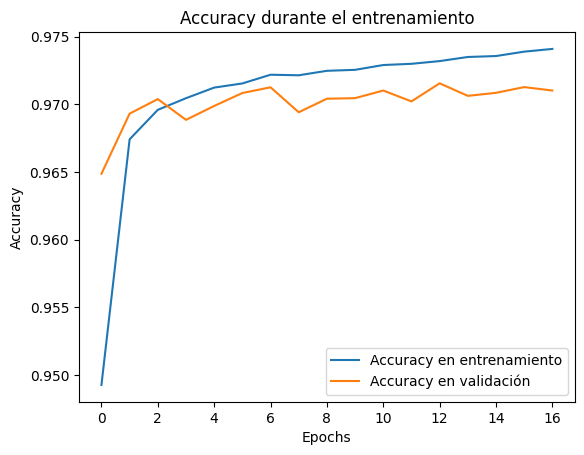

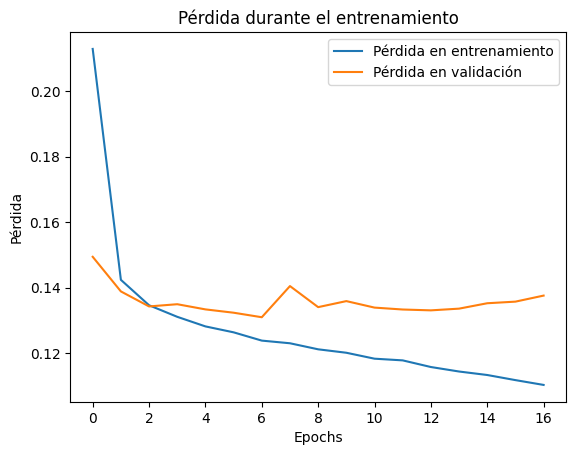

In [164]:
# Graficar el Accuracy
plt.plot(hist1.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(hist1.history['val_accuracy'], label='Accuracy en validación')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Graficar la pérdida
plt.plot(hist1.history['loss'], label='Pérdida en entrenamiento')
plt.plot(hist1.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [170]:
importances = np.abs(model1.layers[0].get_weights()[0]).sum(axis=1)
feature_importances = sorted(zip(selected_columns, importances), key=lambda x: x[1], reverse=True)

for feature, importance in feature_importances:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: last_pymnt_amnt, Importance: 28.782615661621094
Feature: next_pymnt_d_2016-03-01, Importance: 28.628978729248047
Feature: next_pymnt_d_2016-01-01, Importance: 27.095855712890625
Feature: out_prncp, Importance: 25.48779296875
Feature: out_prncp_inv, Importance: 25.324939727783203
Feature: emp_title_tfidf_20416, Importance: 22.930049896240234
Feature: recoveries, Importance: 22.461462020874023
Feature: emp_title_tfidf_45758, Importance: 21.81027603149414
Feature: next_pymnt_d_2016-02-01, Importance: 19.383865356445312
Feature: emp_title_tfidf_16409, Importance: 19.314062118530273
Feature: desc_tfidf_17354, Importance: 19.29351806640625
Feature: desc_tfidf_10173, Importance: 18.404878616333008
Feature: total_rec_int, Importance: 18.377798080444336
Feature: emp_title_tfidf_11703, Importance: 18.27968978881836
Feature: emp_title_tfidf_6318, Importance: 18.169713973999023
Feature: emp_title_tfidf_34403, Importance: 18.058086395263672
Feature: desc_tfidf_31600, Importance: 17.5785617

### Modelo 2

In [165]:
model2 = models.Sequential()
model2.add(layers.Dense(128, activation="relu", input_shape=(X_train.shape[1],)))
model2.add(layers.Dropout(0.5))
# model2.add(layers.Dense(256, activation="relu"))
# model2.add(layers.Dense(128, activation="relu"))
# model2.add(layers.BatchNormalization())
model2.add(layers.Dense(64, activation="relu"))
model2.add(layers.Dense(9, activation="softmax"))

model2.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy", Precision()])
model2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_55 (Dense)            (None, 128)               128000    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_56 (Dense)            (None, 64)                8256      
                                                                 
 dense_57 (Dense)            (None, 9)                 585       
                                                                 
Total params: 136,841
Trainable params: 136,841
Non-trainable params: 0
_________________________________________________________________


In [166]:

checkpoint2 = ModelCheckpoint(
    filepath="../models/best_model2.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

hist2 = model2.fit(partial_x_train, partial_y_train,
                 epochs=20,
                 batch_size=512,
                 validation_data=(x_val, y_val),
                 callbacks=[early_stopping, checkpoint2])

Epoch 1/20


c:\Users\JUAN\anaconda3\envs\envML\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_14/dense_55/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_14/dense_55/embedding_lookup_sparse/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_14/dense_55/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


1248/1248 [==============================] - ETA: 0s - loss: 0.2503 - accuracy: 0.9399 - precision_10: 0.9496
Epoch 1: val_loss improved from inf to 0.15630, saving model to ../models\best_model2.h5
1248/1248 [==============================] - 73s 57ms/step - loss: 0.2503 - accuracy: 0.9399 - precision_10: 0.9496 - val_loss: 0.1563 - val_accuracy: 0.9630 - val_precision_10: 0.9639
Epoch 2/20
1248/1248 [==============================] - ETA: 0s - loss: 0.1651 - accuracy: 0.9610 - precision_10: 0.9623
Epoch 2: val_loss improved from 0.15630 to 0.14254, saving model to ../models\best_model2.h5
1248/1248 [==============================] - 78s 61ms/step - loss: 0.1651 - accuracy: 0.9610 - precision_10: 0.9623 - val_loss: 0.1425 - val_accuracy: 0.9674 - val_precision_10: 0.9680
Epoch 3/20
1247/1248 [============================>.] - ETA: 0s - loss: 0.1519 - accuracy: 0.9646 - precision_10: 0.9654
Epoch 3: val_loss improved from 0.14254 to 0.13858, saving model to ../models\best_model2.h5
124

In [169]:
matrics_model2 = model2.evaluate(X_test, y_test)
print("Accuracy: ", matrics_model2[1])

5547/5547 [==============================] - 27s 5ms/step - loss: 0.1358 - accuracy: 0.9702 - precision_10: 0.9708
Accuracy:  0.9701988101005554


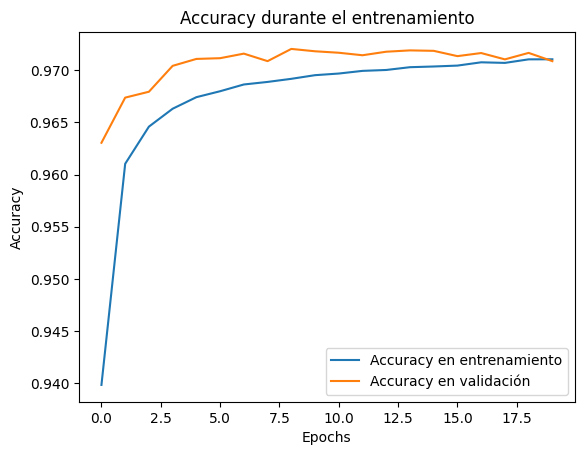

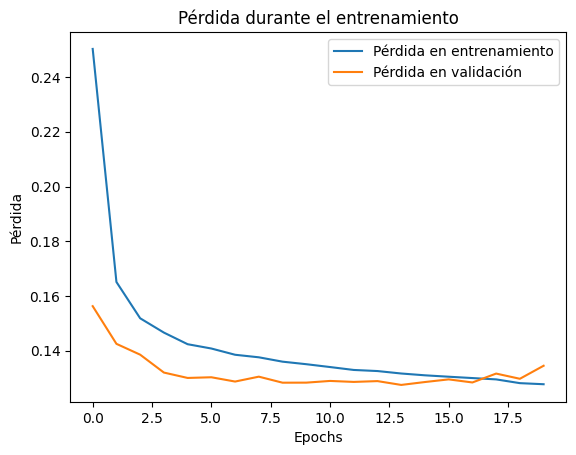

In [168]:
# Graficar el Accuracy
plt.plot(hist2.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(hist2.history['val_accuracy'], label='Accuracy en validación')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Graficar la pérdida
plt.plot(hist2.history['loss'], label='Pérdida en entrenamiento')
plt.plot(hist2.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [171]:
importances = np.abs(model2.layers[0].get_weights()[0]).sum(axis=1)
feature_importances = sorted(zip(selected_columns, importances), key=lambda x: x[1], reverse=True)

for feature, importance in feature_importances:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: next_pymnt_d_2016-01-01, Importance: 45.943763732910156
Feature: last_pymnt_amnt, Importance: 40.75502014160156
Feature: next_pymnt_d_2016-02-01, Importance: 38.4001579284668
Feature: emp_title_tfidf_51883, Importance: 37.598812103271484
Feature: emp_title_tfidf_6318, Importance: 36.500980377197266
Feature: out_prncp, Importance: 35.10958480834961
Feature: out_prncp_inv, Importance: 35.075016021728516
Feature: next_pymnt_d_2016-03-01, Importance: 34.76089096069336
Feature: emp_title_tfidf_33473, Importance: 32.24140548706055
Feature: recoveries, Importance: 32.01150894165039
Feature: emp_title_tfidf_11703, Importance: 30.379240036010742
Feature: emp_title_tfidf_40120, Importance: 29.766033172607422
Feature: desc_tfidf_17092, Importance: 29.7623233795166
Feature: emp_title_tfidf_34403, Importance: 29.268604278564453
Feature: desc_tfidf_28241, Importance: 28.786447525024414
Feature: desc_tfidf_4038, Importance: 28.55275535583496
Feature: emp_title_tfidf_32576, Importance: 28.068